In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
%load_ext line_profiler
%load_ext memory_profiler

In [3]:
varinfo.clear()

In [4]:
module = fc.eightb.preselection.t8btag_minmass
dout = "compare_trainings_bkg"

In [5]:
# signal = ObjIter([])
signal = ObjIter([ Tree(f, report=False) for f in tqdm(module.signal_list) ])

# bkg = ObjIter([])
bkg = ObjIter([ Tree(module.Run2_UL18.QCD_B_List), Tree(module.Run2_UL18.TTJets)])

data = ObjIter([])
# data = ObjIter([ Tree(module.Run2_UL18.JetHT_Data_UL_List) ])

100%|██████████| 1/1 [00:02<00:00,  2.04s/it]


In [6]:
bkg.reweight(2.3)
bkg.set_systematics(0.2)

[None, None]

In [7]:
def n_presel_jets(t):
    t.extend(n_presel_jet=t.n_jet)
(signal+bkg+data).apply(n_presel_jets)

[None, None, None, None, None]

In [8]:
# (signal+bkg).apply(lambda t : build_collection(t, 'H\dY\d_b\d', 'jet', ordered='pt'), report=True)
t8btag = CollectionFilter('jet', filter=lambda t: ak_rank(-t.jet_btag, axis=-1) < 8)
signal = signal.apply(t8btag)
bkg = bkg.apply(t8btag)
data = data.apply(t8btag)

100%|██████████| 1/1 [00:00<00:00,  3.31it/s]


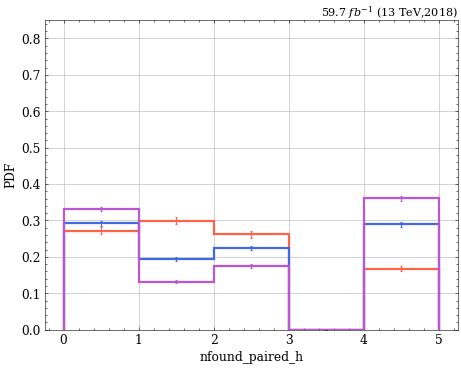

In [20]:
study.quick(
    signal,
    masks=lambda t : t.nfound_select_h == 4,
    efficiency=True,
    ylim=(0.,0.85), grid=True,
    varlist=['nfound_paired_h']
)

In [9]:
networks = dict(
    # mp='/uscms_data/d3/ekoenig/8BAnalysis/studies/weaver-multiH/weaver/models/quadh_ranker_mp/20221124_ranger_lr0.0047_batch512_m7m10m12/',
    mpbkg00='/uscms_data/d3/ekoenig/8BAnalysis/studies/weaver-multiH/weaver/models/quadh_ranker_mp/20221209_b72001172c5d04183ed7bb294252320b_ranger_lr0.0047_batch1024_m7m10m12_withbkg/',
    # mpbkg005='/uscms_data/d3/ekoenig/8BAnalysis/studies/weaver-multiH/weaver/models/quadh_ranker_mp/20221212_293790a7fbfb752ded05771058bf5a25_ranger_lr0.0047_batch1024_m7m10m12_withbkg/',
    mpbkg01='/uscms_data/d3/ekoenig/8BAnalysis/studies/weaver-multiH/weaver/models/quadh_ranker_mp/20221209_be9efb5b61eb1c42aeb209728eec84d7_ranger_lr0.0047_batch1024_m7m10m12_withbkg/',
)

In [10]:
def nfound_higgs(t):
    nhiggs = ak.sum(t.higgs_signalId>-1,axis=-1)
    t.extend(nfound_paired_h=nhiggs)

class Networks:
    def __init__(self, signal, bkg, data, quadh_path=None):
        self.signal = signal.copy()
        self.bkg = bkg.copy()
        self.data = data.copy()

        self.quadh_path = quadh_path

        (self.signal+self.bkg+self.data).apply(lambda t : eightb.load_quadh(t, quadh_path), report=True)
        self.signal.apply(nfound_higgs)

        event_filter = FilterSequence(
            eightb.selected_jet_pt(),
            eightb.selected_jet_btagwp()
        )

        self.signal = self.signal.apply(event_filter)
        self.bkg = self.bkg.apply(event_filter)
        self.data = self.data.apply(event_filter)

In [11]:
models = {
    key : Networks(signal, bkg, data, path)
    for key, path in networks.items()
}

100%|██████████| 5/5 [00:11<00:00,  2.33s/it]


In [13]:
model = models['mpbkg01']

 25%|██▌       | 1/4 [00:00<00:00,  3.15it/s]

[ERROR] Unable to fit


 50%|█████     | 2/4 [00:00<00:00,  3.17it/s]

[ERROR] Unable to fit


100%|██████████| 4/4 [00:01<00:00,  3.57it/s]

[ERROR] Unable to fit


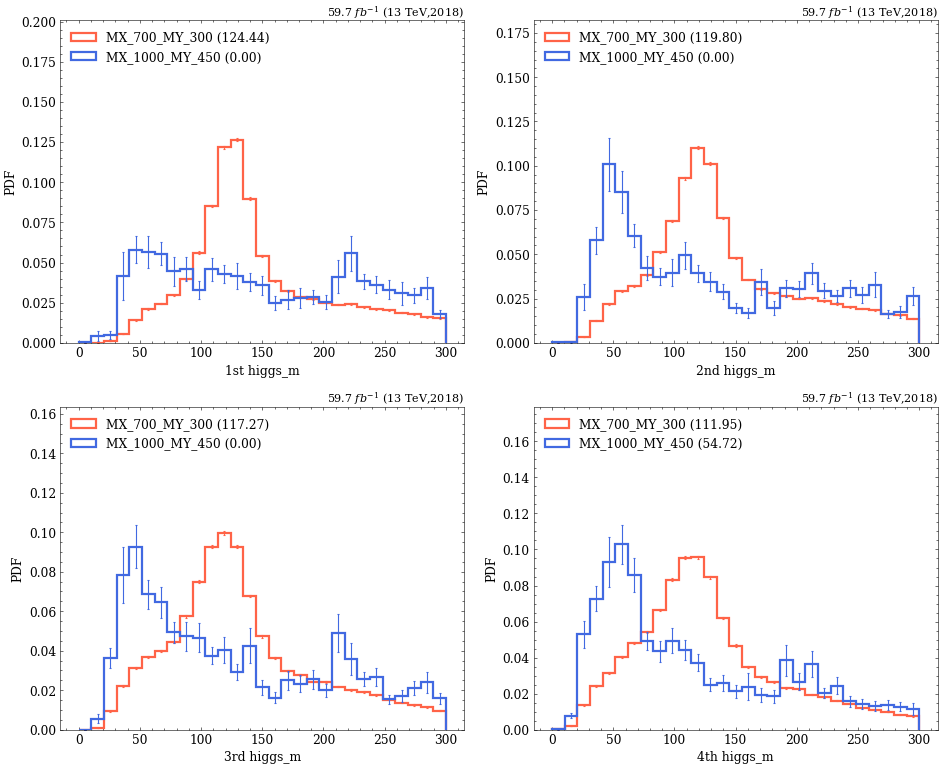

In [19]:
study.quick_region( 
    model.signal,model.bkg,
    legend=True, efficiency=True,
    varlist=[f'higgs_m[:,{i}]' for i in range(4)],
    binlist=[(0,300,30)]*4,
    h_fit='gaussian', h_fit_peak=True, h_label_stat='{fit.mu:0.2f}'

)

In [105]:
def higgs_dm(self, center, use_val=False):
    def _higgs_dm(t):
        dm = ak.zeros_like(t.Run)
        for i, m in enumerate(center):
            dm = dm + ( t.higgs_m[:,i] - m )**2
        dm = np.sqrt(dm)
        if use_val:
            t.extend(val_higgs_dm = dm)
        else:
            t.extend(higgs_dm = dm)
    (self.signal+self.bkg).apply(_higgs_dm)

In [106]:
signal_m = model.signal.higgs_m.cat

In [107]:
def find_best_ar(center):
    dm = ak.zeros_like(signal_m[:,0])
    for i, m in enumerate(center):
        dm = dm + ( signal_m[:,i] - m )**2
    dm = np.sqrt(dm)
    return ak.mean(dm > 30)

In [108]:
from scipy.optimize import fmin

best_ar_center = fmin(find_best_ar, [125,125,125,125])
best_ar_center

Optimization terminated successfully.
         Current function value: 0.934910
         Iterations: 70
         Function evaluations: 163


array([123.90589696, 118.60097966, 118.67491504, 114.38514737])

100%|██████████| 1/1 [00:00<00:00,  5.06it/s]


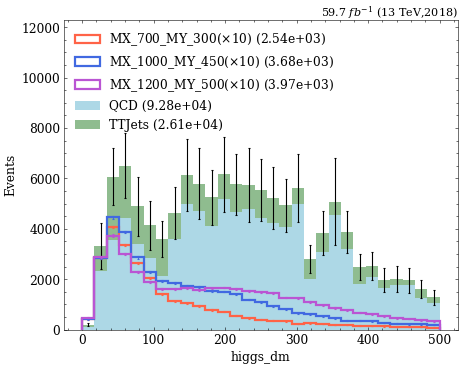

In [109]:
higgs_dm(model, best_ar_center)
# higgs_dm(model, [125,125])

study.quick( 
    model.signal+model.bkg,
    # efficiency=True, 
    plot_scale=[10]*3,
    legend=True,
    varlist=['higgs_dm'],
    binlist=[(0,500,30)],
)

In [133]:
find_vr_center = lambda x : ( np.sum((best_ar_center-x)**2) - 300**2 )**2

best_vr_center = fmin(find_vr_center, 300).repeat(4)
best_vr_center

Optimization terminated successfully.
         Current function value: 0.000251
         Iterations: 22
         Function evaluations: 44


array([268.85373116, 268.85373116, 268.85373116, 268.85373116])

100%|██████████| 1/1 [00:00<00:00,  4.50it/s]


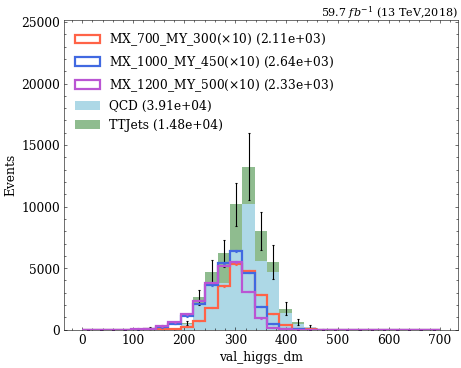

In [135]:
higgs_dm(model, best_vr_center, use_val=True)
# higgs_dm(model, [125,125])

study.quick( 
    model.signal+model.bkg,
    # efficiency=True, 
    masks=lambda t : t.higgs_dm < 200,
    plot_scale=[10]*3,
    legend=True,
    varlist=['val_higgs_dm'],
    binlist=[(0,700,30)],
)

100%|██████████| 4/4 [00:00<00:00,  4.01it/s]


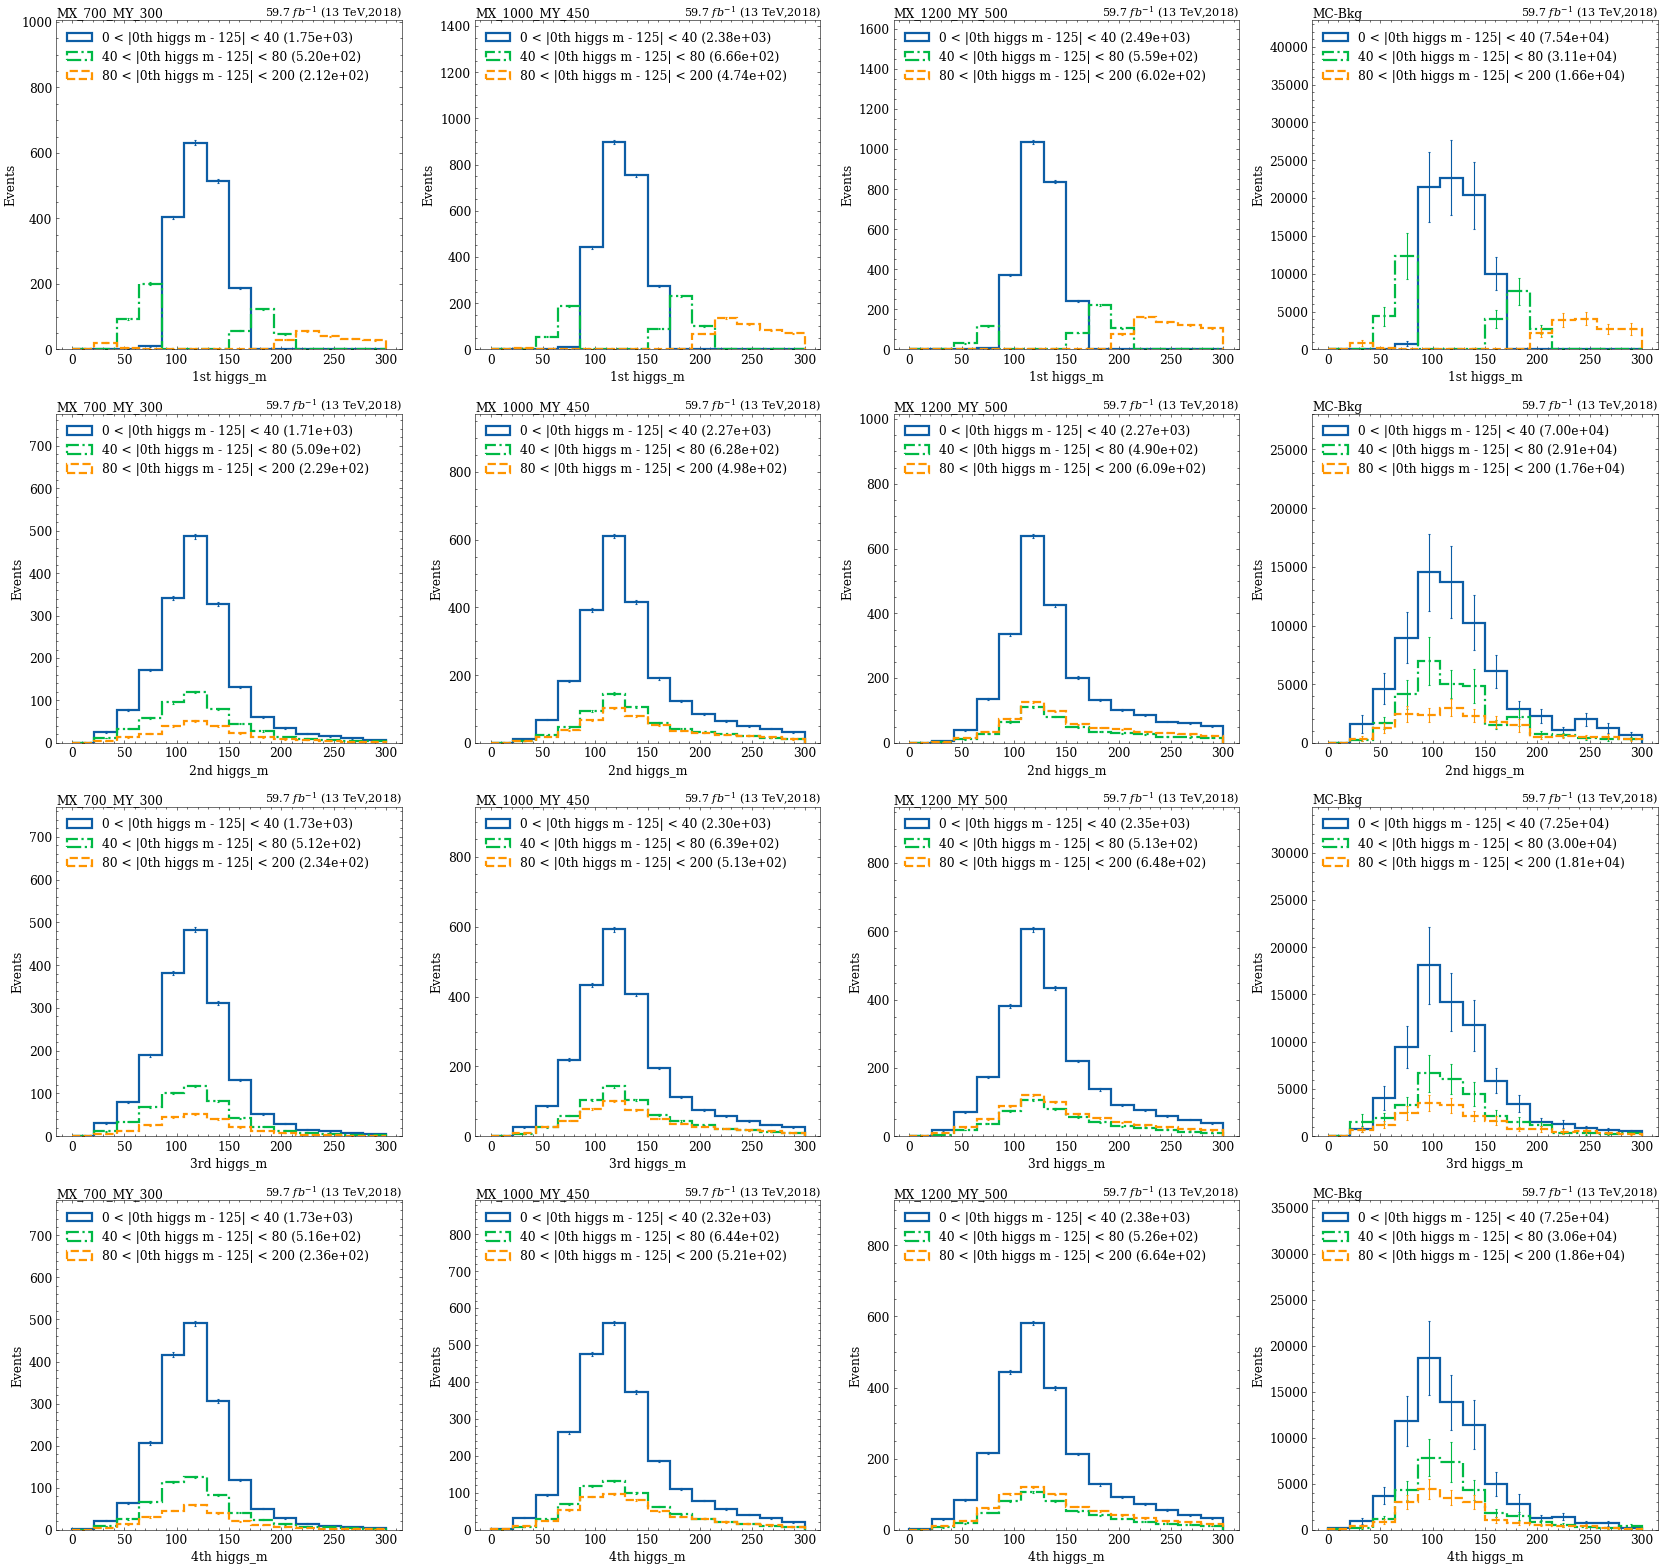

In [151]:
model = models['mpbkg00']
study.compare_masks( 
    model.signal,model.bkg,
    legend=True,
    masks=[higgs_dm_cut(i=0, r=125, lo=lo, hi=hi) for lo,hi in [(0,40),(40,80),(80,200)]],
    h_color=None,
    varlist=[f'higgs_m[:,{i}]' for i in range(4)],
    binlist=[(0,300,15)]*4,
)

100%|██████████| 4/4 [00:01<00:00,  3.82it/s]


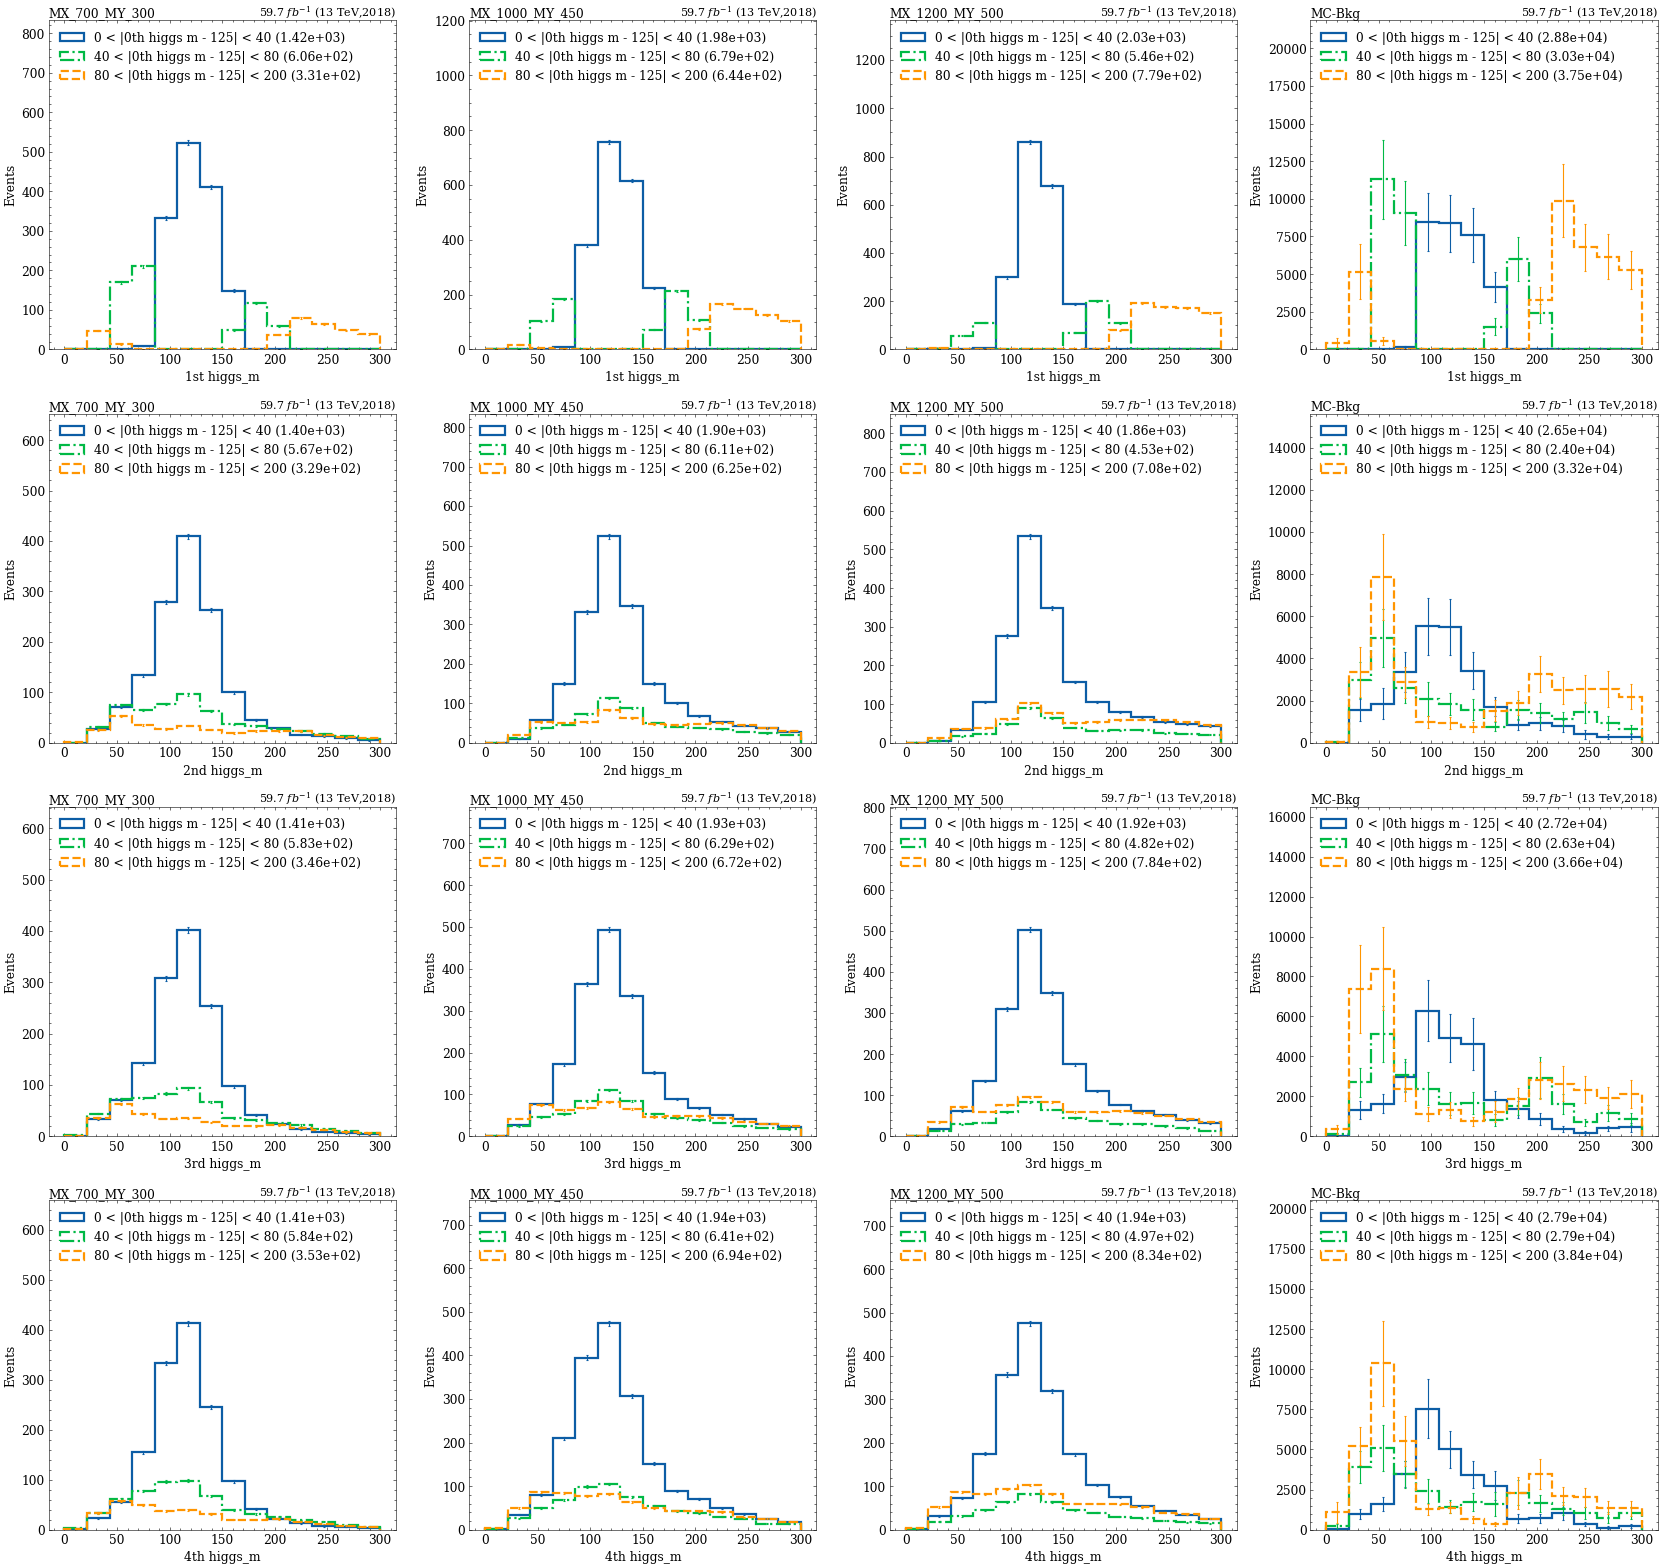

In [150]:
class higgs_dm_cut(ObjTransform):
    @property
    def __name__(self): return f'{self.lo} < |{ordinal(self.i)} higgs m - {self.r}| < {self.hi}'
    def __call__(self, t):
        dm = np.abs(t.higgs_m[:, self.i]-self.r)
        return (dm < self.hi) & (dm > self.lo)

study.compare_masks( 
    model.signal,model.bkg,
    legend=True,
    masks=[higgs_dm_cut(i=0, r=125, lo=lo, hi=hi) for lo,hi in [(0,40),(40,80),(80,200)]],
    h_color=None,
    varlist=[f'higgs_m[:,{i}]' for i in range(4)],
    binlist=[(0,300,15)]*4,
)

100%|██████████| 1/1 [00:00<00:00,  3.74it/s]


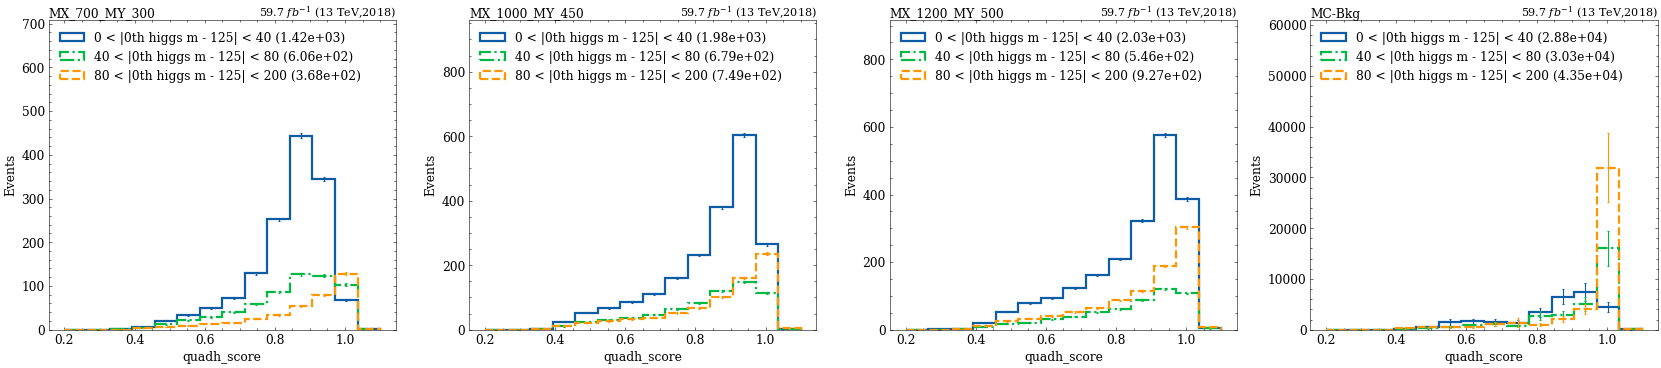

In [154]:
model = models['mpbkg01']
study.compare_masks( 
    model.signal,model.bkg,
    legend=True,
    masks=[higgs_dm_cut(i=0, r=125, lo=lo, hi=hi) for lo,hi in [(0,40),(40,80),(80,200)]],
    h_color=None,
    varlist=['quadh_score'],
    binlist=[(0.2,1.1,15)]
)

100%|██████████| 1/1 [00:00<00:00,  9.22it/s]


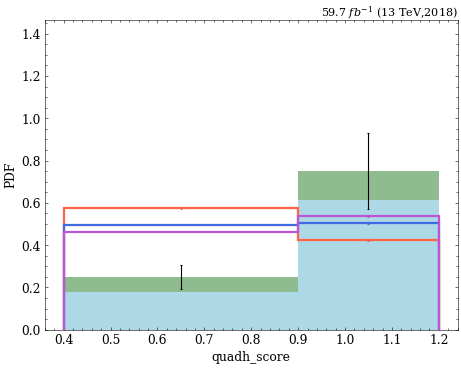

In [175]:
study.quick( 
    model.signal+model.bkg,
    efficiency=True,
    varlist=['quadh_score'],
    binlist=[np.array([0.4,0.9,1.2])]
)

100%|██████████| 4/4 [00:00<00:00,  5.45it/s]


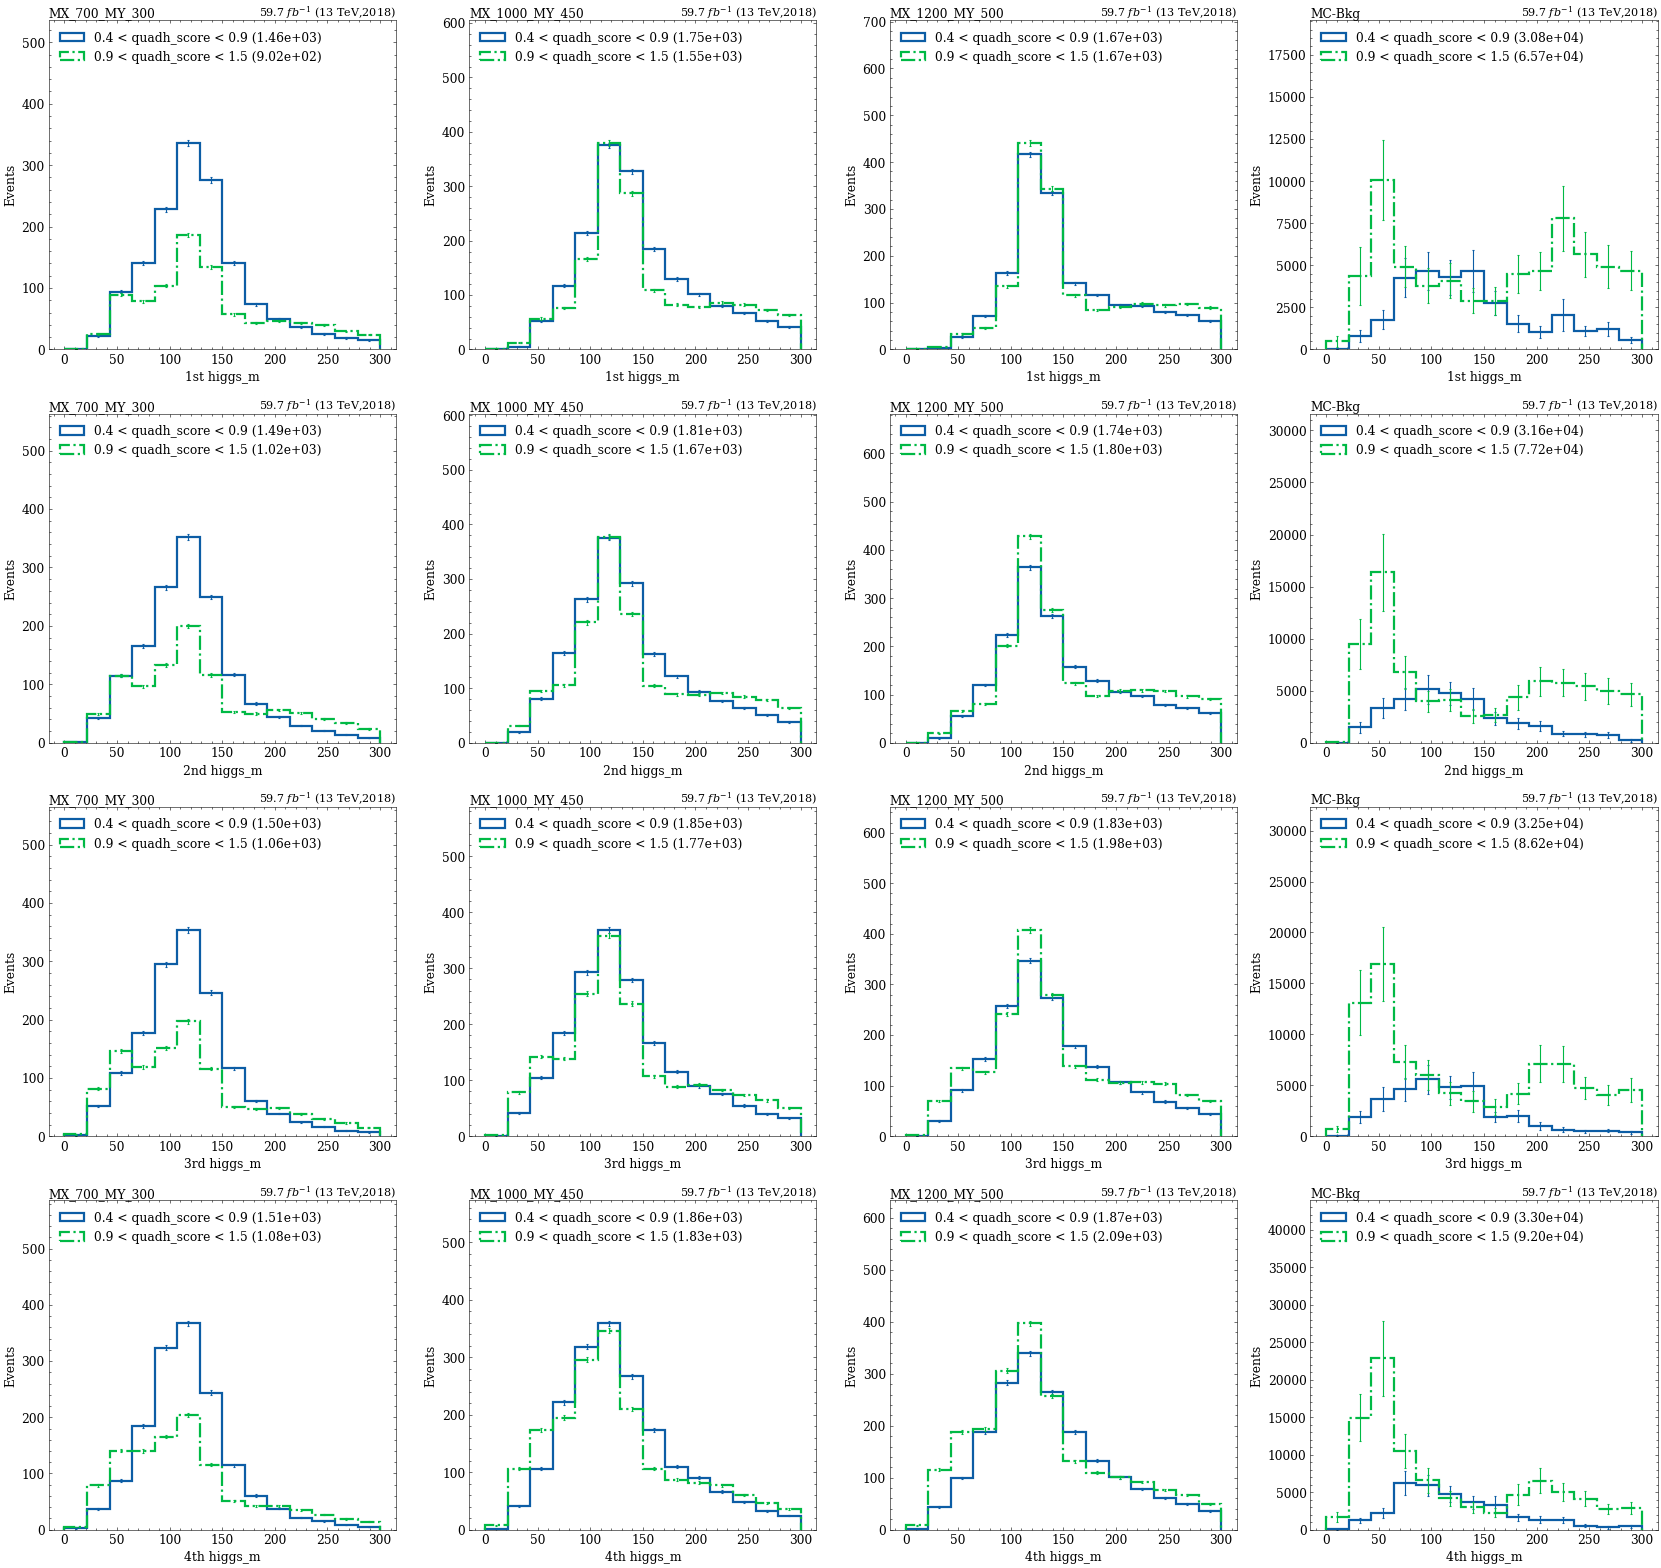

In [176]:
class quadh_score_cut(ObjTransform):
    @property
    def __name__(self): return f'{self.lo} < quadh_score < {self.hi}'
    def __call__(self, t):
        score = t.quadh_score
        return (score < self.hi) & (score > self.lo)

model = models['mpbkg01']
study.compare_masks( 
    model.signal,model.bkg,
    legend=True,
    masks=[quadh_score_cut(lo=lo,hi=hi) for lo,hi in [(0.4,0.9),(0.9,1.5)]],
    h_color=None,
    varlist=[f'higgs_m[:,{i}]' for i in range(4)],
    binlist=[(0,300,15)]*4,
)

In [77]:
def model_2d_higgs_m(self, center):
    study.quick2d(
            self.signal+self.bkg,
            xvarlist=['higgs_m[:,0]',],
            yvarlist=['higgs_m[:,1]',],
            binlist=[(0,400,30)]*2,
            exe=[
                draw_concentric(*center[:2], 50, 70, label='- AR -\nTotal: {total_count:0.2e}({total_eff:0.2%})\nSR: {inner_count:0.2e}({inner_eff:0.2%})\nCR: {outer_count:0.2e}({outer_eff:0.2%})', text=(0.05,0.9), linewidth=2),
                draw_concentric(125,125, 50, 70, label='- 2R -\nTotal: {total_count:0.2e}({total_eff:0.2%})\nSR: {inner_count:0.2e}({inner_eff:0.2%})\nCR: {outer_count:0.2e}({outer_eff:0.2%})', text=(0.5,0.9), linewidth=2),
                # draw_concentric(*self.vr_center[:2], self.sr_r, self.cr_r, label='- VR -\nTotal: {total_count:0.2e}({total_eff:0.2%})\nSR: {inner_count:0.2e}({inner_eff:0.2%})\nCR: {outer_count:0.2e}({outer_eff:0.2%})', text=(0.5,0.9), linewidth=2),
            ],
            scatter=True,
        )

100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


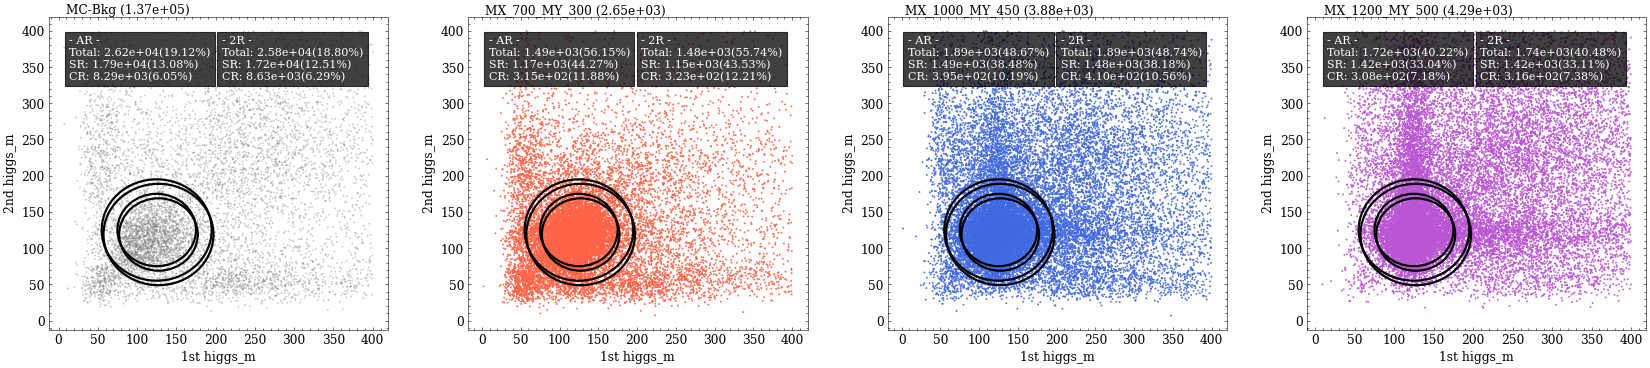

In [78]:
model_2d_higgs_m(model, best_ar_center)

100%|██████████| 1/1 [00:00<00:00,  9.04it/s]


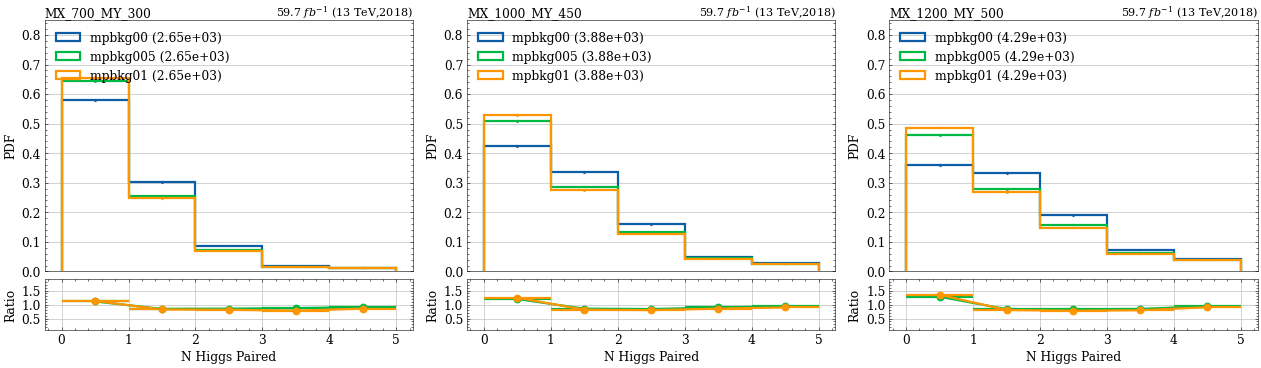

In [12]:
fig, axs = study.get_figax(nvar=3, dim=-1)
for i, sample in enumerate(signal):
    study.quick( 
        [ model.signal[i] for model in models.values() ],
        label = [ model for model in models ],
        text=(0.0, 1.0, sample.sample),
        text_style=dict(ha='left', va='bottom'),
        h_color=None,
        legend=True,
        efficiency=True,
        ylim=(0,0.85), grid=True,
        varlist=['nfound_paired_h'],
        xlabels=['N Higgs Paired'],
        ratio=True, r_inv=True,
        figax=(fig, axs.flat[i])
    )

study.save_fig(fig, 'compare_bkg/t8btag_signal_reco_eff')

100%|██████████| 1/1 [00:00<00:00,  3.96it/s]


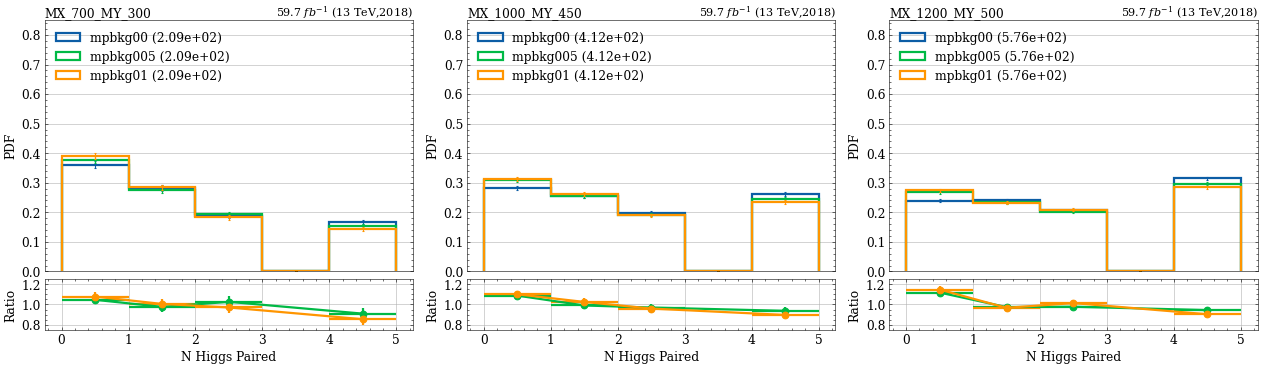

In [13]:
fig, axs = study.get_figax(nvar=3, dim=-1)
for i, sample in enumerate(signal):
    study.quick( 
        [ model.signal[i] for model in models.values() ],
        masks=lambda t : t.nfound_select_h==4,
        label = [ model for model in models ],
        text=(0.0, 1.0, sample.sample),
        text_style=dict(ha='left', va='bottom'),
        h_color=None,
        legend=True,
        efficiency=True,
        ylim=(0,0.85), grid=True,
        varlist=['nfound_paired_h'],
        xlabels=['N Higgs Paired'],
        ratio=True, r_inv=True, r_ylim=(0.7501,1.249),
        figax=(fig, axs.flat[i])
    )

study.save_fig(fig, 'compare_bkg/fullres_signal_reco_eff')

100%|██████████| 4/4 [00:01<00:00,  3.30it/s]


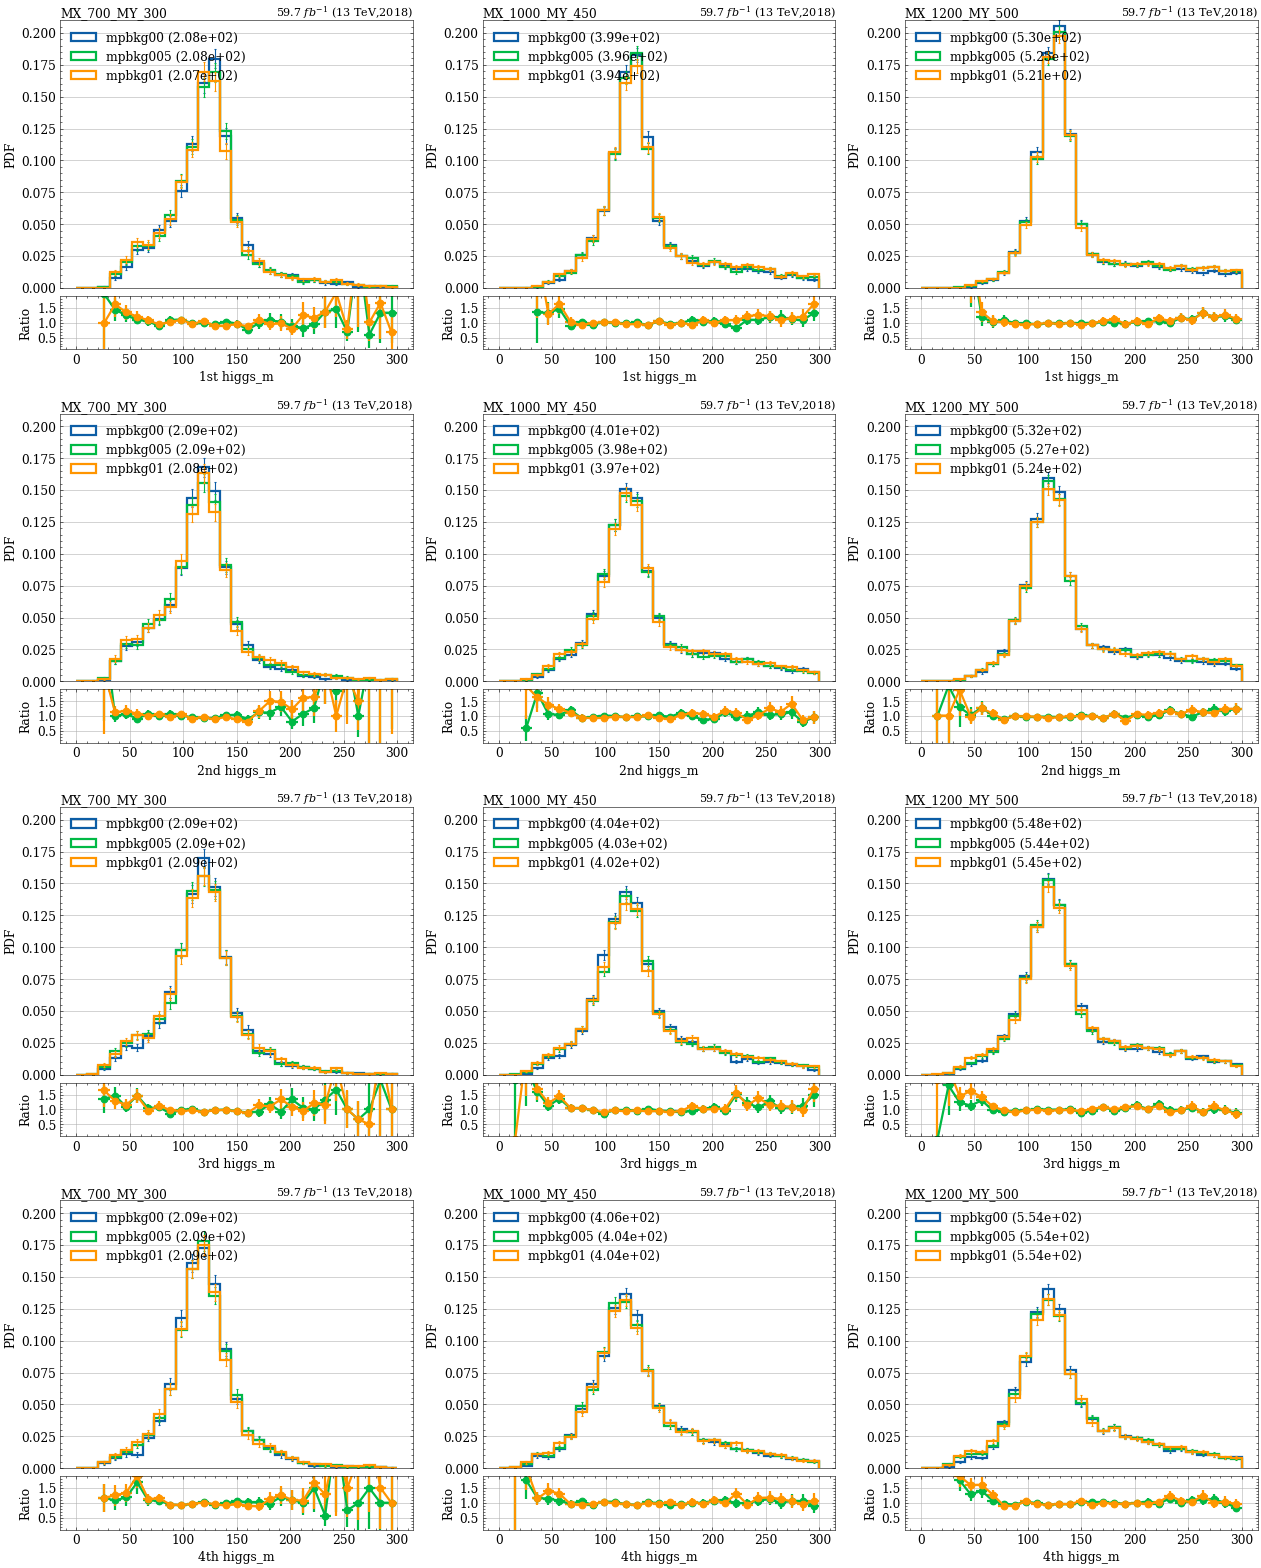

In [14]:
fig, axs = study.get_figax(nvar=3*4, dim=(-1, 3))
for i, sample in enumerate(signal):
    study.quick( 
        [ model.signal[i] for model in models.values() ],
        masks=lambda t : t.nfound_select_h==4,
        label = [ model for model in models ],
        text=(0.0, 1.0, sample.sample),
        text_style=dict(ha='left', va='bottom'),
        h_color=None,
        legend=True,
        efficiency=True,
        ylim=(0,0.21), grid=True,
        varlist=[f'higgs_m[:,{i}]' for i in range(4) ],
        binlist=[(0,300,30)]*4,
        ratio=True, r_inv=True,
        figax=(fig, axs[:,i])
    )

study.save_fig(fig, 'compare_bkg/fullres_signal_higgs_m')

100%|██████████| 4/4 [00:00<00:00,  7.94it/s]


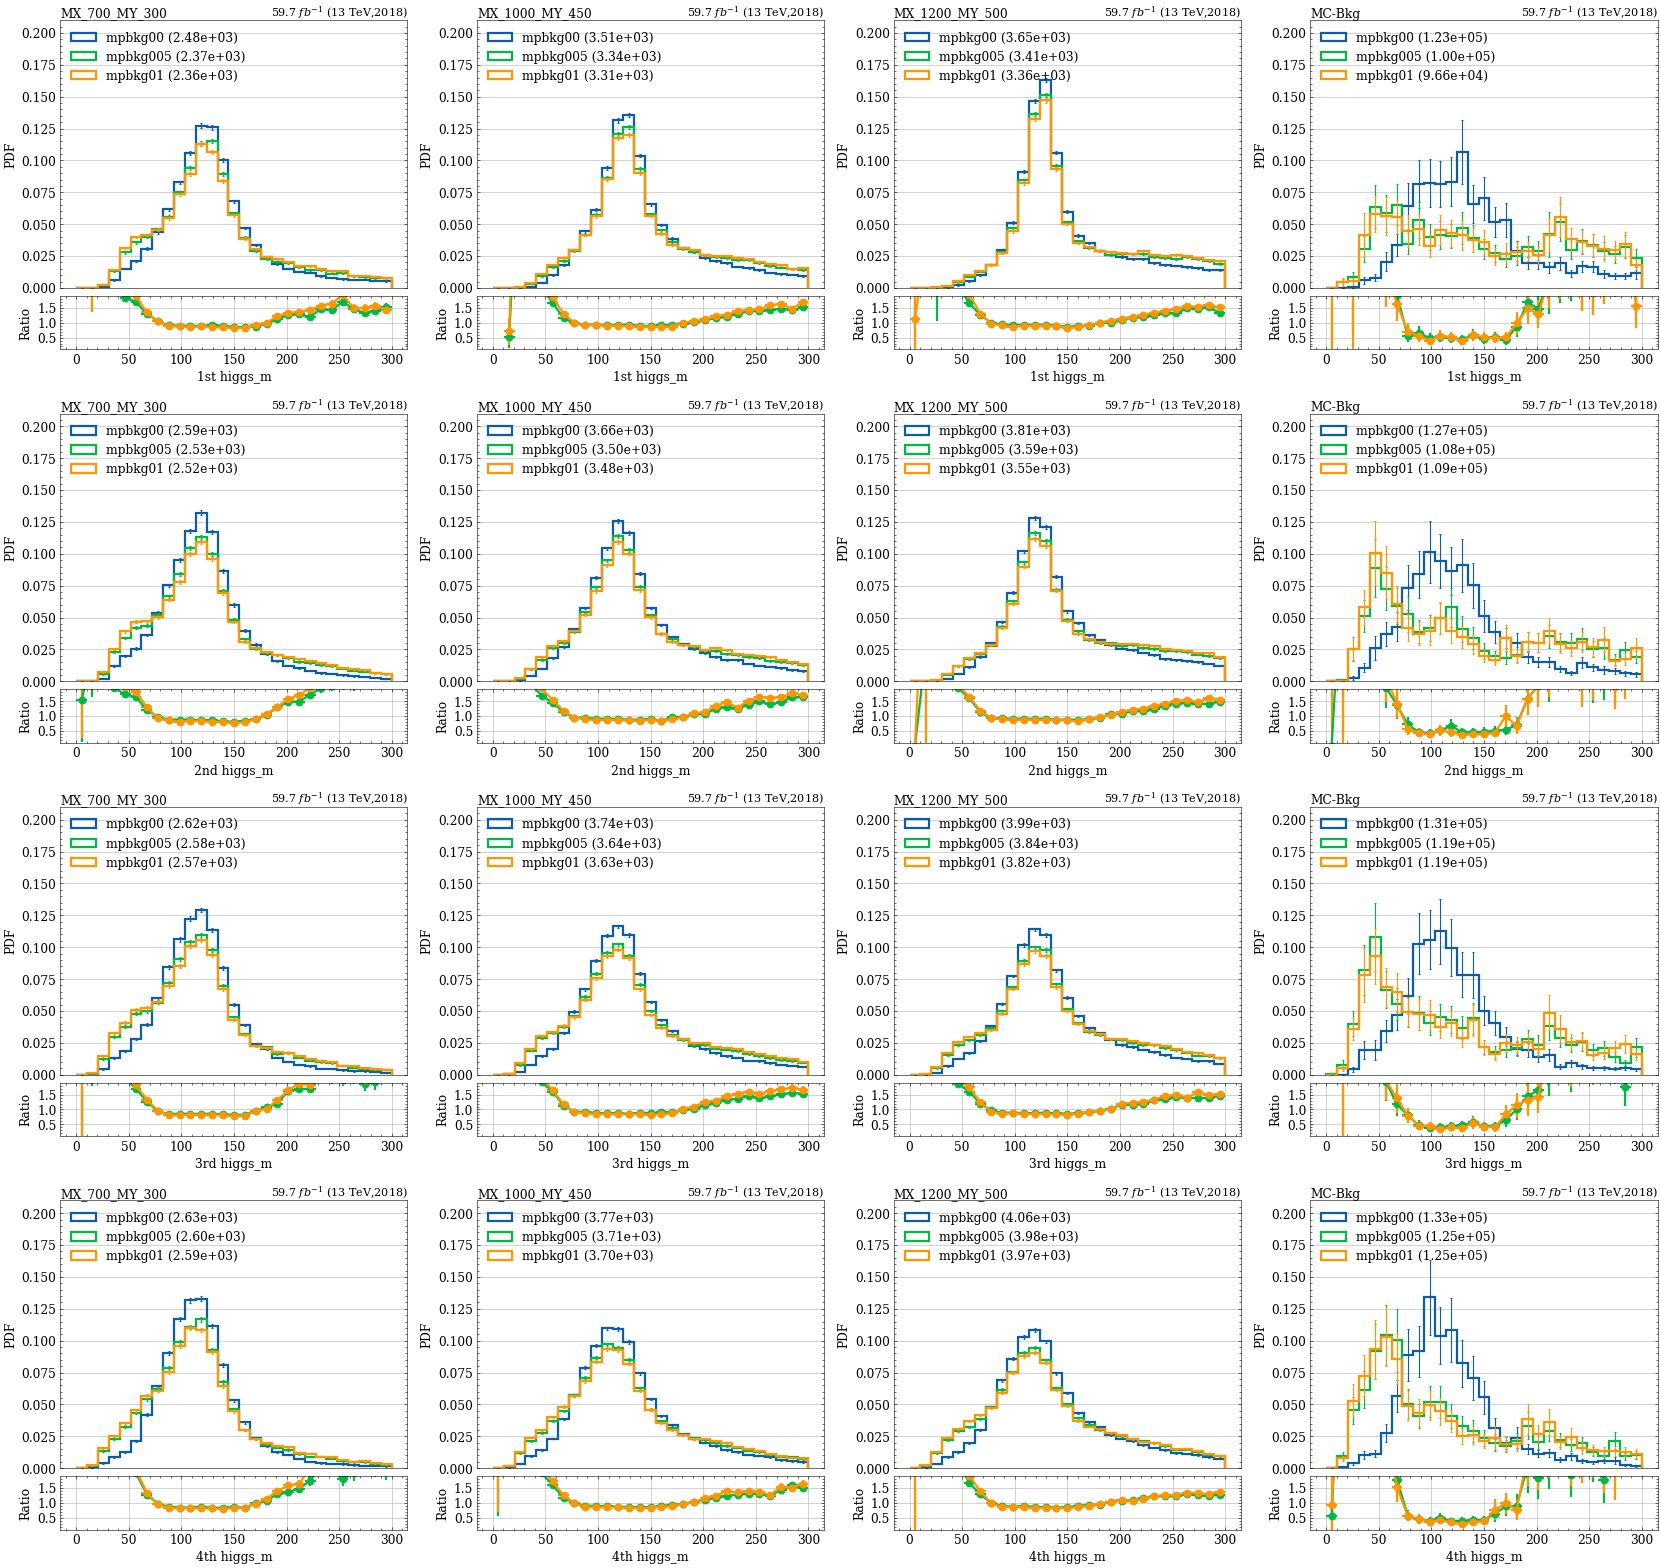

In [15]:
fig, axs = study.get_figax(nvar=4*4, dim=(-1,4))

kwargs = dict(
    label = [ model for model in models ],
    text_style=dict(ha='left', va='bottom'),
    h_color=None,
    legend=True,
    efficiency=True,
    ylim=(0,0.21), grid=True,
    varlist=[f'higgs_m[:,{i}]' for i in range(4)],
    binlist=[(0,300,30)]*4,
    ratio=True, r_inv=True,
)

for i, sample in enumerate(signal):
    study.quick( 
        [ model.signal[i] for model in models.values() ],
        text=(0.0, 1.0, sample.sample),
        figax=(fig, axs[:,i]),
        **kwargs
    )

study.quick_region( 
        *[ model.bkg for model in models.values() ],
        text=(0.0, 1.0, 'MC-Bkg'),
        figax=(fig, axs[:,i+1]),
        **kwargs
    )

study.save_fig(fig, 'compare_bkg/t8btag_higgs_m')

100%|██████████| 4/4 [00:00<00:00,  5.51it/s]


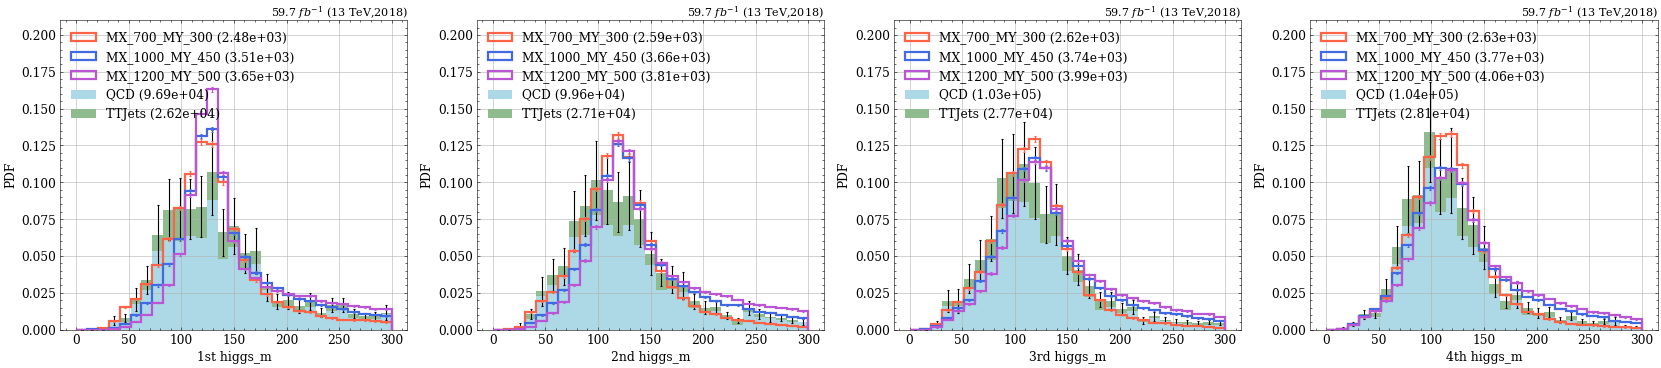

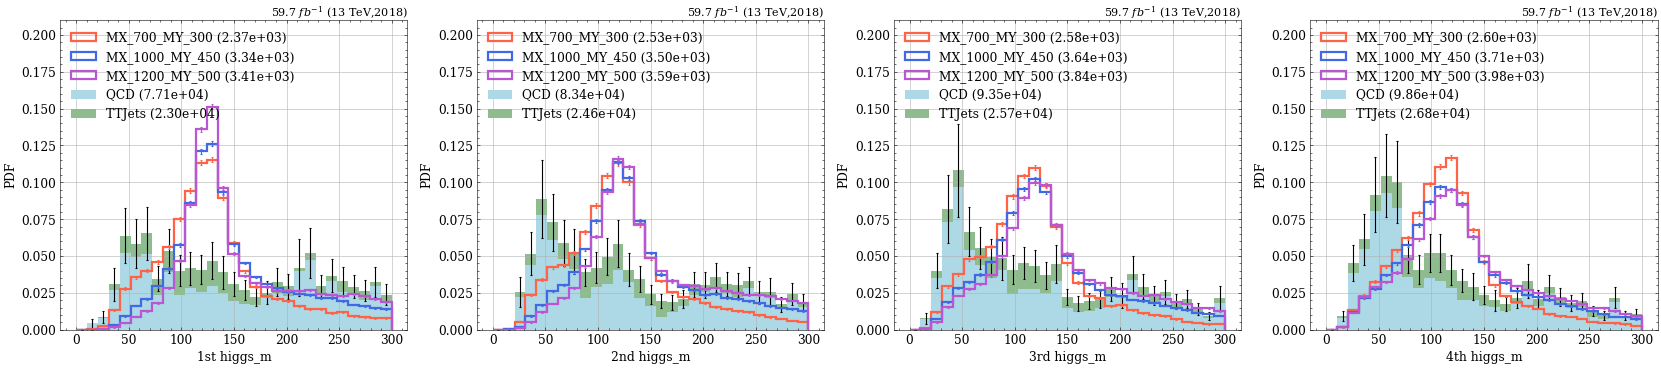

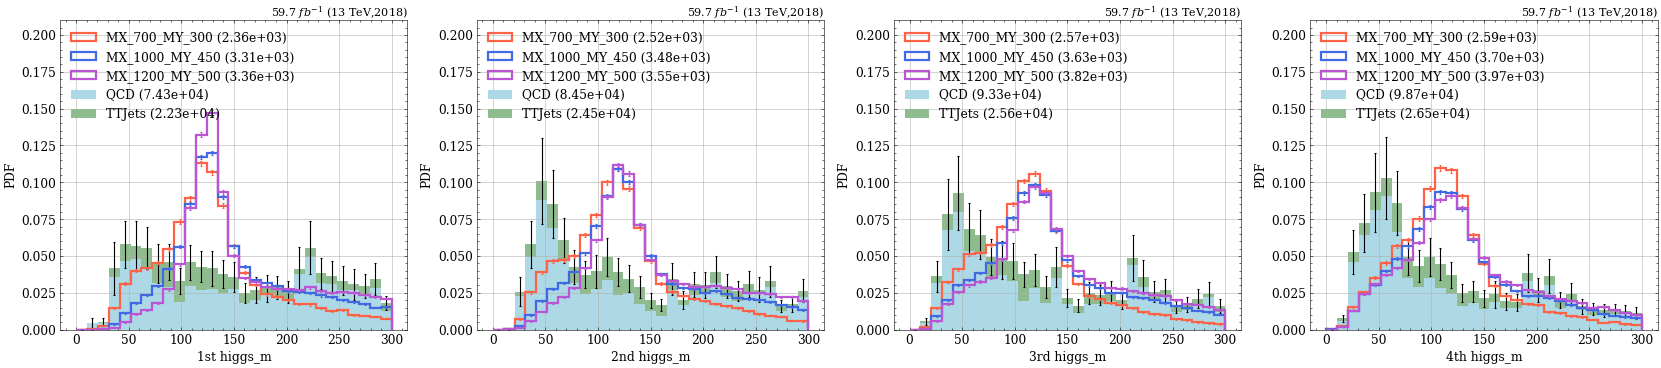

In [16]:

kwargs = dict(
    text_style=dict(ha='left', va='bottom'),
    # h_color=None,
    legend=True,
    efficiency=True,
    ylim=(0,0.21), grid=True,
    varlist=[f'higgs_m[:,{i}]' for i in range(4)],
    binlist=[(0,300,30)]*4,
    dim=-1,
    # ratio=True, r_inv=True,
)

for key, model in models.items():
    study.quick( 
        model.signal+model.bkg,
        **kwargs,
        saveas=f'compare_bkg/{key}_higgs_m'
    )

# study.save_fig(fig, 'compare_bkg/t8btag_higgs_m')

100%|██████████| 2/2 [00:09<00:00,  4.67s/it]


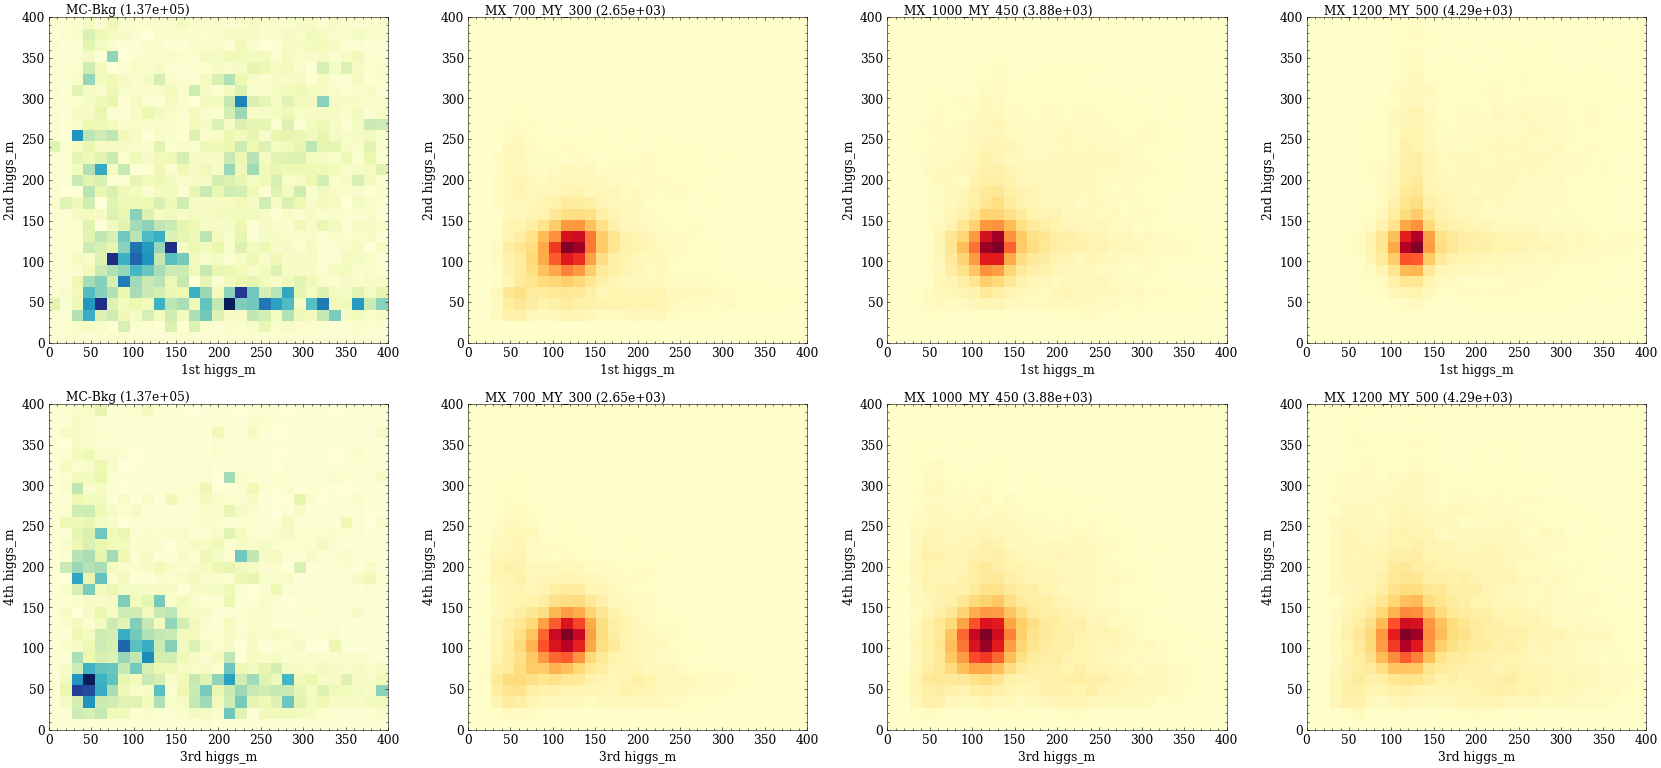

In [17]:
study.quick2d(
    model.signal+model.bkg,
    varlist=[f'higgs_m[:,{i}]' for i in range(4)],
    binlist=[(0,400,30)]*4,
    efficiency=True,
)